# Pricing : excess of rain cover

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import xarray as xr
from numpy.testing import assert_allclose
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2

# Context

A client is looking to be covered against excess of rain.

You will first manipulate rasters and then use historical data to understand the risk.

# 1. Parameters

In [2]:
DATA_PATH = Path("data")
RASTERS_PATH = DATA_PATH / "rasters"

# 2. Data

## 2.1 Load data

In [3]:
vegetation_path = RASTERS_PATH / "vegetation.nc"
precipitation_path = RASTERS_PATH / "precipitation.nc"

In [7]:
vegetation_xr = xr.load_dataset(vegetation_path)
precipitation_xr = xr.load_dataset(precipitation_path)

## 2.2 Visualize data

Let's look at the coordinates values:

In [8]:
print(vegetation_xr.latitude.values[:2])

[-4755784.4062485 -4756034.4062485]


The coordinate reference system (crs) here is named an equal-area crs which means that the areas are preserved when projecting the earth to a plane. The unit of the coordinates is **meters**. See more info [there](https://en.wikipedia.org/wiki/Spatial_reference_system).

In [9]:
precipitation_xr

<xarray.Dataset> Size: 244MB
Dimensions:        (latitude: 48, longitude: 48, time: 26433)
Coordinates:
  * latitude       (latitude) float64 384B -4.756e+06 -4.756e+06 ... -4.76e+06
  * longitude      (longitude) float64 384B 1.275e+06 1.276e+06 ... 1.28e+06
  * time           (time) datetime64[ns] 211kB 1950-01-01 ... 2022-05-15
    spatial_ref    int64 8B 0
Data variables:
    precipitation  (latitude, longitude, time) float32 244MB 0.0 0.0 ... 0.0 0.0

One can notice that the precipitation raster has time variable. We then have access of cumulative daily precipitation data since the 1st of January 1950

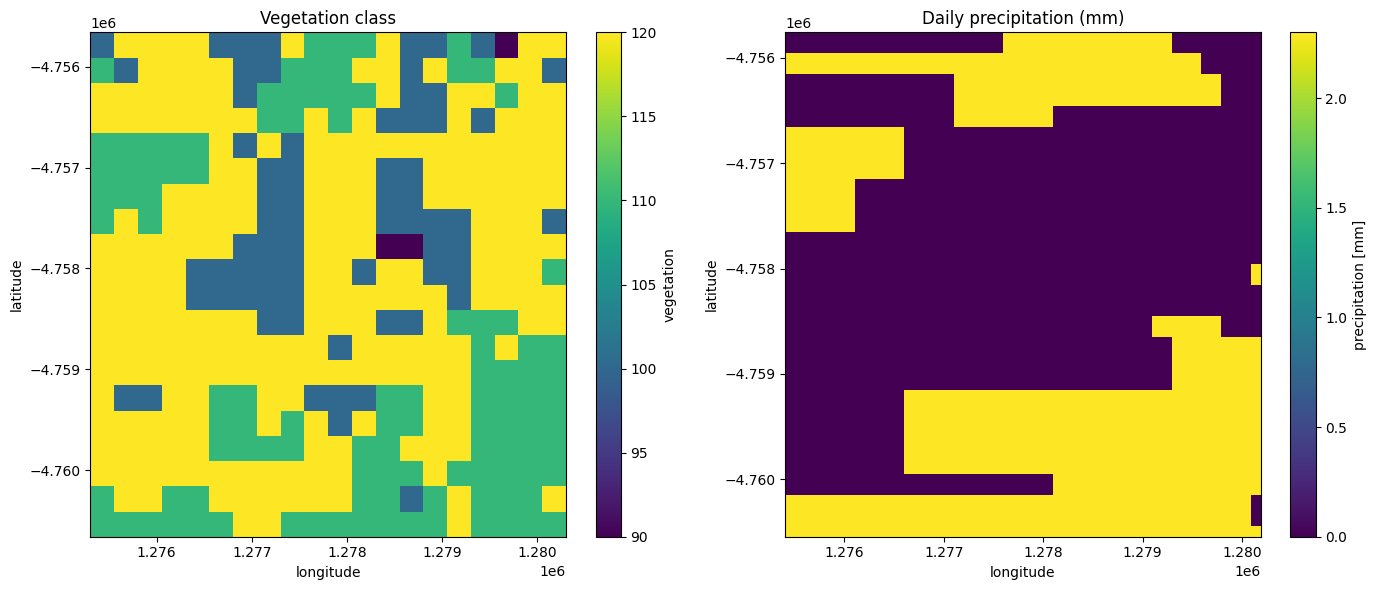

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
vegetation_xr.vegetation.plot(ax=ax[0])
ax[0].set_title("Vegetation class")
precipitation_xr.precipitation[dict(time=3)].plot(ax=ax[1])
ax[1].set_title("Daily precipitation (mm)")
ax[1].set_xlabel("longitude")
ax[1].set_ylabel("latitude")
plt.tight_layout()
plt.show()

The vegetation raster is a gridded array of categorical values with information on the type of the dominant vegetation of each pixel.

    - Class 90 : Water and urban areas
    - Class 100: Herbaceous class
    - Class 110: Forest class
    - Class 120: Shrubland class
    
For example, the pixel at location (longitude 1277929.24, latitude -4758284.41) displays a value of 120, meaning that the vegetation at this location is shrubland.

#### What is each raster's resolution (in meters)?

The resolution is defined as the distance between the centres of 2 neighbour pixels.

In [ ]:
# NOTE: fill me!


# Comme il s'agit de carrés on ne pourrait en théorie n'utiliser qu'une seule variable mais en l'occurence pour être sûr je vais utiliser les deux 
lat, lon = vegetation_xr.latitude.values, vegetation_xr.longitude.values
res_lat, res_lon = np.abs(np.diff(lat)).mean(), np.abs(np.diff(lon)).mean()

#print(f"Résolution nord-sud (latitude/y) : {res_lat} mètres")
#print(f"Résolution est-ouest (longitude/x) : {res_lon} mètres")

vegetation_resolution = int(res_lat)
########

lat, lon = precipitation_xr.latitude.values, precipitation_xr.longitude.values
res_lat, res_lon = np.abs(np.diff(lat)).mean(), np.abs(np.diff(lon)).mean()

#print(f"Résolution nord-sud (latitude/y) : {res_lat} mètres")
#print(f"Résolution est-ouest (longitude/x) : {res_lon} mètres")

# Comme la valeur vaut 99,999 ; en prenant la fonction int on ne récupère que 99 c'est pour cela que j'ai arrondi à 100 via round
precipitation_resolution = int(round(res_lat, 1))

Résolution nord-sud (latitude/y) : 250.0 mètres
Résolution est-ouest (longitude/x) : 250.0 mètres


In [ ]:
assert isinstance(vegetation_resolution, int)
assert isinstance(precipitation_resolution, int)

# 3. Manipulate rasters

### 3.1 Change rasters' resolution

Your task is to get the precipitation for all grid cells in the forest class (value of 110). Unfortunately, the 2 rasters do not have the same resolution. Your task will be to reindex the 2 rasters at the **same** resolution.

The resolution of each raster should be the finest one out of the 2 intial datasets.

To downscale (move from coarse to finer resolution), you will use the function `xarray.interp()`: https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interp.html

In [ ]:
# NOTE: fill me!

vegetation_downscaled_xr = "fill with proper raster"
precipitation_downscaled_xr = "fill with proper raster"

In [ ]:
assert isinstance(vegetation_downscaled_xr, xr.Dataset)
assert isinstance(precipitation_downscaled_xr, xr.Dataset)

## 3.2 Compute mean precipitation

The client has forests that span over all the area showed by the raster, which means that all grid cells in forest class belong to the client.

**Task**

Your task is to compute the mean daily precipitation for grid cells only in **forest class**. You may want to use the function [`xarray.where()`](https://docs.xarray.dev/en/stable/generated/xarray.where.html).

The output will be a dataframe `df_rain_historical` with the dates as index with name `Date` and the column daily precipitation renamed `daily_rain`. You could use the function [`xarray.to_dataframe()`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.to_dataframe.html)

In [ ]:
# NOTE: fill me!

In [ ]:
assert df_rain_historical.index.name == "Date"

## 3.3 Next steps

The previous task helped you to compute the daily precipitation for one day at the client's locations. We actually have access to 70 years of historical data and that's the object of the next steps. The data from the previous part has been extracted at the client location into a dataframe that you will use from now on

# 4. Pricing

## 4.1 Context

The client is looking to be covered against excess of rain.

The client wishes to receive a payout under the following conditions:
+ Depends on the cumulative rainfall (mm) over the season.
+ Linear payout starting at a deductible of 650 mm and limit of 750 mm with a payout of AUD 500,000.

It means that 
+ If the cumulative rainfall is below 650 mm, the client receives nothing.
+ If the cumulative rainfall is above 750 mm, the client receives the max payout of AUD 500,000 no matter the loss.
+ If the cumulative rainfall is between 650 and 750 mm, the payout is linear, slope of AUD 5,000 per mm. For example, if the cumulative rainfall is 700 mm, the payout would be AUD 250,000.


## 4.2 Data

We have access to the cumulative rainfall (in millimeters-mm) each day since 1950 January 1st using the task before.

## 4.3 Preprocessing

### 4.3.1 Filtering

**Risk period**

The client would like to be covered from the 1st of December of a given year until 1st of March of the following year (**not included**).

**Task**
- Filter the historical dates to keep only the ones in the risk periods. ⚠️ You should not have incomplete seasons. ⚠️
- Remove the rows with the date equal to February 29th.
- Create a `season` column, the value of the season is the year corresponding to the 1st of December. For example, for the given risk period 1st of December 2021 - 1st of March 2022, the season is 2021.

In [ ]:
# NOTE: fill me!

In [ ]:
assert list(df_rain_historical.columns) == ["daily_rain", "season"]

### 4.3.2 Regroup by season

**Task**

- Create a new dataframe `df_cum_rain` by regrouping by season and by computing the cumulative rainfall over the risk period.
- Rename the column `daily_rain` by `cum_rain`.

In [ ]:
# NOTE: fill me!

## 4.4 Compute payouts

Using the current values of `cum_rain`, we will now compute the historical payouts.

**Task**
- Design a function that computes the payouts using the structure defined above.
- Compute historical payouts since 1950 by creating a new dataframe `df_historical_payouts` with column `hist_payouts`. 

The resulting mean value of historical payouts is called **burning cost** and corresponds to the mean payout the client would have received based on the historica data. This is an important metrics in the design of insurance covers.

In [ ]:
# NOTE: fill me!

## 4.5 Weighting

### 4.5.1 Year type

We actually have access to historical yearly forecasts that states if the year was supposed to be rainy or not. There are 3 predictions:
- neutral
- dry
- rainy

All the information is stored in the dataframe `df_year_type`.

We will use this information to compute a weighted payouts using next year forecast.

In [ ]:
year_type_data_path = DATA_PATH / "pricing" / "year_type_historical.csv"

In [ ]:
df_year_type = (
    pd.read_csv(year_type_data_path, index_col=0)
    .rename(columns={"Year": "season"})
    .set_index("season")
)
df_year_type.head()

**Task**

Do the same computation (historical payouts) for each of the year type (rainy, dry or neutral). Compute the burning cost of each of the year type. What can you observe ?

In [ ]:
# NOTE: fill me!

### 4.5.2 Next year forecast

The forecast for next year is given in terms of probability for each of the year types:

In [ ]:
next_year_forecast = {"dry": 0.58, "neutral": 0.37, "rainy": 0.05}

**Task**

How would you leverage on these forecasts to better estimate the risk and adjust the burning cost ? 

In [ ]:
# NOTE: fill me!

---
# END OF SCRIPT